# DNN applied to the IDS-2017

In this notebook, deep neural networks are used to create binary classifiers that distinguish between benign and malicious traffics in the ids-2017 dataset. Hyperparameters are optimized to obtain a model with the best results.

In [2]:
from notebook_utils import load_processed_dataset_2017, plot_confusion_matrix, metrics_report, upsample_dataset, extract_and_plot_metrics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, average_precision_score, make_scorer, precision_score, accuracy_score, confusion_matrix
%matplotlib inline
%load_ext autoreload
%autoreload 2
file_path = r"CIC-IDS-2017\CSVs\GeneratedLabelledFlows\TrafficLabelling\processed\ids2017_processed.csv"

In [3]:
X_train, Y_train, X_eval, Y_eval, X_test, Y_test, scaler = load_processed_dataset_2017(file_path)

In [4]:
performance_models = {}

In [7]:
# Save the best model
def save_keras_model(model, model_name):
    file_path = f'models/{model_name}.keras'
    model.save(file_path)
    print(f'Model saved to {file_path}')

## 1. Prototype

Epoch 1/50
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 65s 662us/step - accuracy: 0.9370 - loss: 0.1561 - val_accuracy: 0.2789 - val_loss: 5.4997
Epoch 2/50
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 65s 664us/step - accuracy: 0.9537 - loss: 0.1100 - val_accuracy: 0.2945 - val_loss: 9.0536
Epoch 3/50
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 64s 657us/step - accuracy: 0.9555 - loss: 0.1065 - val_accuracy: 0.3193 - val_loss: 5.9944
Epoch 4/50
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 64s 656us/step - accuracy: 0.9565 - loss: 0.1151 - val_accuracy: 0.3333 - val_loss: 6.4783
Epoch 5/50
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 65s 666us/step - accuracy: 0.9572 - loss: 0.1012 - val_accuracy: 0.3396 - val_loss: 8.9501
Epoch 6/50
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 64s 655us/step - accuracy: 0.9575 - loss: 0.1150 - val_accuracy: 0.3347 - val_loss: 6.8928
8847/8847 ━━━━━━━━━━━━━━━━━━━━ 4s 424us/step
Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.9794    0.9808    0.9801    227310


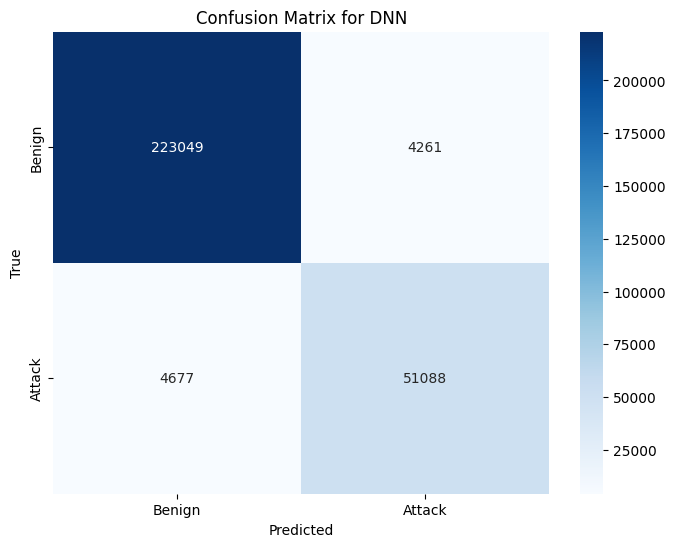

In [6]:
# Define the model architecture
model = Sequential([
    keras.layers.Input(shape=(scaler.transform(X_train).shape[1],)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Add early stopping callback
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(scaler.transform(X_train), Y_train.is_attack, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Predict probabilities on the evaluation set
y_pred_eval_prob = model.predict(scaler.transform(X_eval))
# Convert probabilities to binary predictions
y_pred_eval = (y_pred_eval_prob > 0.5).astype(int)
metrics_report("Evaluation", Y_eval.is_attack, y_pred_eval, print_avg=False)

# Predict and evaluate on the test set
y_pred_test_prob = model.predict(scaler.transform(X_test))
y_pred_test = (y_pred_test_prob > 0.5).astype(int)
metrics_report("Test", Y_test.is_attack, y_pred_test, print_avg=False)
plot_confusion_matrix("DNN", Y_test, y_pred_test)

## 2. Hyperparameter Tuning

In this section, a random grid search is perform in an attempt to find a satisfying model. Previously, these hyperparameters were found to perform best.
{'units_input': 480, 'num_layers': 2, 'units_0': 448, 'dropout_0': 0.30000000000000004, 'learning_rate': 0.00614260757976685, 'units_1': 224, 'dropout_1': 0.0, 'units_2': 256, 'dropout_2': 0.4}

In [5]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=512, step=32), activation='relu', input_shape=(X_train.shape[1],)))
    
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32), activation='relu'))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [6]:
from keras_tuner import RandomSearch

directory_path = os.path.join(os.getcwd(), 'hyperparam_tuning')
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory=directory_path,
    project_name='intrusion_detection'
)

tuner.search_space_summary()

# Perform the search
tuner.search(scaler.transform(X_train), Y_train.is_attack, epochs=10, validation_split=0.2)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hps.values)

Reloading Tuner from G:\Other computers\My PC\stage\ML-NIDS\Notebooks\hyperparam_tuning\intrusion_detection\tuner0.json
Search space summary
Default search space size: 9
units_input (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step'

Best Hyperparameters: {'units_input': 480, 'num_layers': 2, 'units_0': 448, 'dropout_0': 0.30000000000000004, 'learning_rate': 0.00614260757976685, 'units_1': 224, 'dropout_1': 0.0, 'units_2': 256, 'dropout_2': 0.4}

In [7]:
# Build the model with the best hyperparameters
model1 = build_model(best_hps)

# Train the model
history = model1.fit(scaler.transform(X_train), Y_train.is_attack, epochs=20, validation_split=0.2, verbose=1)

save_keras_model(model1, 'DNN_model1')

C:\Users\youss\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 199s 2ms/step - accuracy: 0.9362 - loss: 0.1674 - val_accuracy: 0.2194 - val_loss: 23.5051
Epoch 2/20
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 193s 2ms/step - accuracy: 0.9386 - loss: 0.2016 - val_accuracy: 0.2388 - val_loss: 24.9698
Epoch 3/20
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 194s 2ms/step - accuracy: 0.9180 - loss: 0.2323 - val_accuracy: 0.2713 - val_loss: 7.7734
Epoch 4/20
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 186s 2ms/step - accuracy: 0.9056 - loss: 0.3569 - val_accuracy: 0.4874 - val_loss: 1.3522
Epoch 5/20
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 159s 2ms/step - accuracy: 0.9047 - loss: 0.2874 - val_accuracy: 0.5412 - val_loss: 10.9510
Epoch 6/20
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 181s 2ms/step - accuracy: 0.9040 - loss: 0.3198 - val_accuracy: 0.5865 - val_loss: 8.1861
Epoch 7/20
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 188s 2ms/step - accuracy: 0.9008 - loss: 0.3453 - val_accuracy: 0.5714 - val_loss: 43.7867
Epoch 8/20
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 170s 2ms/step 

8847/8847 ━━━━━━━━━━━━━━━━━━━━ 5s 612us/step
Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.9382    0.9896    0.9632    227310
           1     0.9456    0.7342    0.8266     55764

    accuracy                         0.9393    283074
   macro avg     0.9419    0.8619    0.8949    283074
weighted avg     0.9396    0.9393    0.9363    283074

Accuracy: 0.9393126885549362
8847/8847 ━━━━━━━━━━━━━━━━━━━━ 5s 593us/step
Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9386    0.9894    0.9633    227310
           1     0.9448    0.7359    0.8274     55765

    accuracy                         0.9395    283075
   macro avg     0.9417    0.8627    0.8954    283075
weighted avg     0.9398    0.9395    0.9365    283075

Accuracy: 0.9395071977391151


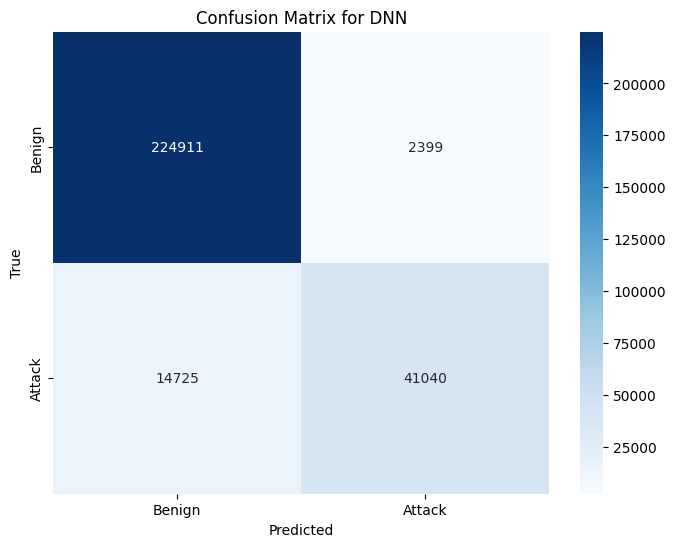

In [8]:
# Predict probabilities on the evaluation set
y_pred_eval_prob = model1.predict(scaler.transform(X_eval))
# Convert probabilities to binary predictions
y_pred_eval = (y_pred_eval_prob > 0.5).astype(int)
metrics_report("Evaluation", Y_eval.is_attack, y_pred_eval, print_avg=False)

# Predict and evaluate on the test set
y_pred_test_prob = model1.predict(scaler.transform(X_test))
y_pred_test = (y_pred_test_prob > 0.5).astype(int)
performance_models["DNN1"] = metrics_report("Test", Y_test.is_attack, y_pred_test, print_avg=False)
plot_confusion_matrix("DNN", Y_test, y_pred_test)

## 3. Hyperparameter tuning with Hypermodel with 2 layers

In [9]:
from tensorflow.keras import layers
import keras_tuner as kt

class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(layers.Input(shape=(X_train.shape[1],)))
        
        model.add(layers.Dense(units=hp.Int('units_input', min_value=32, max_value=512, step=32), activation='relu'))
        model.add(layers.Dropout(rate=hp.Float('dropout_input', min_value=0.0, max_value=0.5, step=0.1)))
        
        for i in range(hp.Int('num_layers', 1, 3)):
            model.add(layers.Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32), activation='relu'))
            model.add(layers.Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))
        
        model.add(layers.Dense(1, activation='sigmoid'))
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model

In [10]:
directory_path = os.path.join(os.getcwd(), 'hyperparam_tuning_hypermodel')
tuner = kt.RandomSearch(
    MyHyperModel(),
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory=directory_path,
    project_name='intrusion_detection_hypermodel'
)

tuner.search_space_summary()

Reloading Tuner from G:\Other computers\My PC\stage\ML-NIDS\Notebooks\hyperparam_tuning_hypermodel\intrusion_detection_hypermodel\tuner0.json
Search space summary
Default search space size: 10
units_input (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_input (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 

In [11]:
# Perform the search
tuner.search(scaler.transform(X_train), Y_train.is_attack, epochs=10, validation_split=0.2)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hps.values)

Best Hyperparameters: {'units_input': 64, 'dropout_input': 0.30000000000000004, 'num_layers': 1, 'units_0': 128, 'dropout_0': 0.1, 'learning_rate': 0.009264436128630775, 'units_1': 96, 'dropout_1': 0.2, 'units_2': 320, 'dropout_2': 0.1}


Best Hyperparameters: {'units_input': 64, 'dropout_input': 0.30000000000000004, 'num_layers': 1, 'units_0': 128, 'dropout_0': 0.1, 'learning_rate': 0.009264436128630775, 'units_1': 96, 'dropout_1': 0.2, 'units_2': 320, 'dropout_2': 0.1}

In [12]:
# Build the model with the best hyperparameters
hypermodel = MyHyperModel()
model2 = hypermodel.build(best_hps)

# Train the model
history = model2.fit(scaler.transform(X_train), Y_train.is_attack, epochs=20, validation_split=0.2, verbose=1)

save_keras_model(model2, 'DNN_model2')

Epoch 1/20
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 64s 646us/step - accuracy: 0.9370 - loss: 0.1576 - val_accuracy: 0.3041 - val_loss: 9.0398
Epoch 2/20
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 65s 663us/step - accuracy: 0.9475 - loss: 0.2043 - val_accuracy: 0.2337 - val_loss: 9.1982
Epoch 3/20
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 64s 662us/step - accuracy: 0.9494 - loss: 0.1583 - val_accuracy: 0.2695 - val_loss: 8.0149
Epoch 4/20
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 65s 666us/step - accuracy: 0.9495 - loss: 0.1577 - val_accuracy: 0.3341 - val_loss: 5.3154
Epoch 5/20
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 64s 662us/step - accuracy: 0.9506 - loss: 0.1349 - val_accuracy: 0.4592 - val_loss: 6.7877
Epoch 6/20
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 65s 663us/step - accuracy: 0.9507 - loss: 0.1667 - val_accuracy: 0.5095 - val_loss: 4.0334
Epoch 7/20
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 64s 660us/step - accuracy: 0.9505 - loss: 0.2866 - val_accuracy: 0.4640 - val_loss: 2.5444
Epoch 8/20
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 65s 664us/s

8847/8847 ━━━━━━━━━━━━━━━━━━━━ 4s 422us/step
Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.9796    0.9642    0.9718    227310
           1     0.8629    0.9180    0.8896     55764

    accuracy                         0.9551    283074
   macro avg     0.9212    0.9411    0.9307    283074
weighted avg     0.9566    0.9551    0.9556    283074

Accuracy: 0.9551177430636512
8847/8847 ━━━━━━━━━━━━━━━━━━━━ 4s 413us/step
Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9792    0.9638    0.9714    227310
           1     0.8613    0.9165    0.8880     55765

    accuracy                         0.9545    283075
   macro avg     0.9202    0.9401    0.9297    283075
weighted avg     0.9559    0.9545    0.9550    283075

Accuracy: 0.9544608319349995


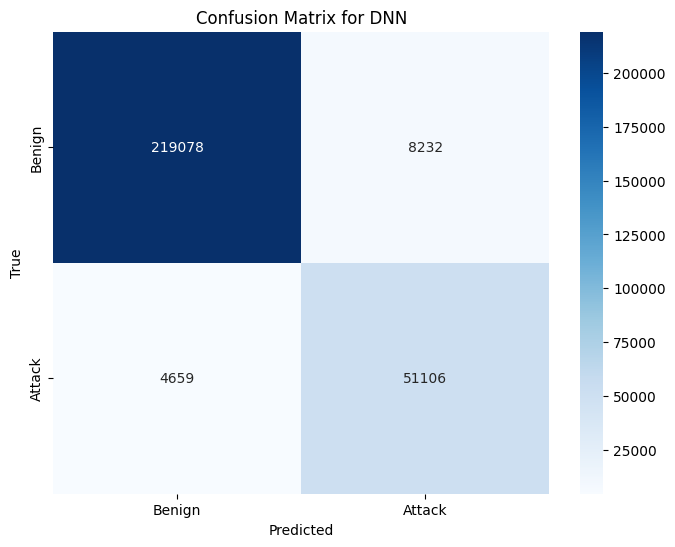

In [13]:
# Predict probabilities on the evaluation set
y_pred_eval_prob = model2.predict(scaler.transform(X_eval))
# Convert probabilities to binary predictions
y_pred_eval = (y_pred_eval_prob > 0.5).astype(int)
metrics_report("Evaluation", Y_eval.is_attack, y_pred_eval, print_avg=False)

# Predict and evaluate on the test set
y_pred_test_prob = model2.predict(scaler.transform(X_test))
y_pred_test = (y_pred_test_prob > 0.5).astype(int)
performance_models["DNN2"] = metrics_report("Test", Y_test.is_attack, y_pred_test, print_avg=False)
plot_confusion_matrix("DNN", Y_test, y_pred_test)

## 4. Hyperparameter Tuning for 3 layers

In [14]:
from tensorflow.keras.layers import Input

# Define the HyperModel class
def build_model2(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units_2', min_value=16, max_value=256, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units_3', min_value=16, max_value=256, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [15]:
# Initialize the tuner
directory_path = os.path.join(os.getcwd(), 'hyperparam_tuning_hypermodel2')
tuner = kt.RandomSearch(
    build_model2,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory=directory_path,
    project_name='intrusion_detection_hypermodel2'
)
tuner.search_space_summary()


Reloading Tuner from G:\Other computers\My PC\stage\ML-NIDS\Notebooks\hyperparam_tuning_hypermodel2\intrusion_detection_hypermodel2\tuner0.json
Search space summary
Default search space size: 7
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_2 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_3 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.00

In [16]:
# Perform the search
tuner.search(scaler.transform(X_train), Y_train.is_attack, epochs=10, validation_split=0.2)
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hps.values)

Best Hyperparameters: {'units_1': 160, 'dropout_1': 0.30000000000000004, 'units_2': 176, 'dropout_2': 0.1, 'units_3': 80, 'dropout_3': 0.30000000000000004, 'learning_rate': 0.001395388438752399}


Best Hyperparameters: {'units_1': 160, 'dropout_1': 0.30000000000000004, 'units_2': 176, 'dropout_2': 0.1, 'units_3': 80, 'dropout_3': 0.30000000000000004, 'learning_rate': 0.001395388438752399}

In [17]:
# Build the model with the best hyperparameters
model3 = build_model2(best_hps)

# Add early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model3.fit(scaler.transform(X_train), Y_train.is_attack, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

save_keras_model(model3, 'DNN_model3')

Epoch 1/50
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 84s 852us/step - accuracy: 0.9483 - loss: 0.1202 - val_accuracy: 0.2989 - val_loss: 3.5517
Epoch 2/50
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 82s 846us/step - accuracy: 0.9582 - loss: 0.0960 - val_accuracy: 0.4244 - val_loss: 3.1263
Epoch 3/50
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 82s 844us/step - accuracy: 0.9590 - loss: 0.0976 - val_accuracy: 0.4823 - val_loss: 2.1240
Epoch 4/50
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 82s 845us/step - accuracy: 0.9591 - loss: 0.2004 - val_accuracy: 0.4903 - val_loss: 1.5908
Epoch 5/50
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 82s 843us/step - accuracy: 0.9591 - loss: 0.2509 - val_accuracy: 0.5100 - val_loss: 2.1942
Epoch 6/50
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 82s 840us/step - accuracy: 0.9593 - loss: 0.0987 - val_accuracy: 0.5200 - val_loss: 2.1992
Epoch 7/50
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 82s 843us/step - accuracy: 0.9590 - loss: 0.0979 - val_accuracy: 0.4766 - val_loss: 4.7340
Epoch 8/50
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 83s 848us/s

8847/8847 ━━━━━━━━━━━━━━━━━━━━ 4s 450us/step
Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.9831    0.9692    0.9761    227310
           1     0.8815    0.9320    0.9060     55764

    accuracy                         0.9619    283074
   macro avg     0.9323    0.9506    0.9411    283074
weighted avg     0.9631    0.9619    0.9623    283074

Accuracy: 0.96191455237853
8847/8847 ━━━━━━━━━━━━━━━━━━━━ 4s 442us/step
Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9830    0.9683    0.9756    227310
           1     0.8783    0.9319    0.9043     55765

    accuracy                         0.9612    283075
   macro avg     0.9307    0.9501    0.9400    283075
weighted avg     0.9624    0.9612    0.9616    283075

Accuracy: 0.9611551708911066


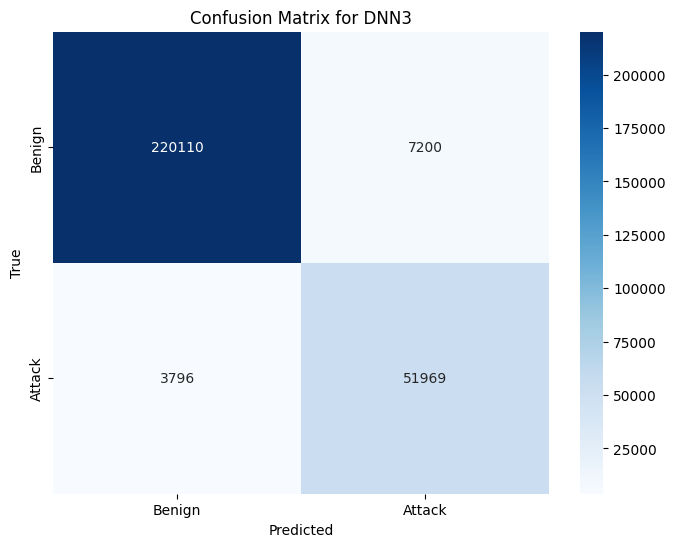

In [18]:
# Evaluate the best model
# Predict probabilities on the evaluation set
y_pred_eval_prob = model3.predict(scaler.transform(X_eval))
# Convert probabilities to binary predictions
y_pred_eval = (y_pred_eval_prob > 0.5).astype(int)
metrics_report("Evaluation", Y_eval.is_attack, y_pred_eval, print_avg=False)

# Predict and evaluate on the test set
y_pred_test_prob = model3.predict(scaler.transform(X_test))
y_pred_test = (y_pred_test_prob > 0.5).astype(int)
performance_models["DNN3"] = metrics_report("Test", Y_test.is_attack, y_pred_test, print_avg=False)
plot_confusion_matrix("DNN3", Y_test, y_pred_test)

## 5. Hyperparameter Tuning with 4 layers

In [19]:
# Define the build_model3 function with four dense layers
def build_model3(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units_2', min_value=16, max_value=256, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units_3', min_value=16, max_value=256, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units_4', min_value=16, max_value=256, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_4', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [20]:
# Initialize the tuner
directory_path = os.path.join(os.getcwd(), 'hyperparam_tuning_hypermodel3')
tuner = kt.RandomSearch(
    build_model3,  
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory=directory_path,
    project_name='intrusion_detection_hypermodel3'
)
tuner.search_space_summary()

Reloading Tuner from G:\Other computers\My PC\stage\ML-NIDS\Notebooks\hyperparam_tuning_hypermodel3\intrusion_detection_hypermodel3\tuner0.json
Search space summary
Default search space size: 9
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_2 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_3 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value

In [21]:
# Perform the search
tuner.search(scaler.transform(X_train), Y_train['is_attack'], epochs=10, validation_split=0.2)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hps.values)

Best Hyperparameters: {'units_1': 192, 'dropout_1': 0.4, 'units_2': 16, 'dropout_2': 0.30000000000000004, 'units_3': 16, 'dropout_3': 0.4, 'units_4': 208, 'dropout_4': 0.30000000000000004, 'learning_rate': 0.0025675045227976654}


Best Hyperparameters: {'units_1': 192, 'dropout_1': 0.4, 'units_2': 16, 'dropout_2': 0.30000000000000004, 'units_3': 16, 'dropout_3': 0.4, 'units_4': 208, 'dropout_4': 0.30000000000000004, 'learning_rate': 0.0025675045227976654}

In [22]:
# Build the model with the best hyperparameters
model4 = build_model3(best_hps)
# Add early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Train the model
history = model4.fit(scaler.transform(X_train), Y_train.is_attack, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
save_keras_model(model4, 'DNN_model4')

Epoch 1/50
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 80s 810us/step - accuracy: 0.9361 - loss: 0.1683 - val_accuracy: 0.3888 - val_loss: 2.8339
Epoch 2/50
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 79s 807us/step - accuracy: 0.9498 - loss: 0.1208 - val_accuracy: 0.3020 - val_loss: 7.9926
Epoch 3/50
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 79s 807us/step - accuracy: 0.9504 - loss: 0.1189 - val_accuracy: 0.3899 - val_loss: 7.1006
Epoch 4/50
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 79s 807us/step - accuracy: 0.9509 - loss: 0.1244 - val_accuracy: 0.2968 - val_loss: 6.0990
Epoch 5/50
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 82s 845us/step - accuracy: 0.9512 - loss: 0.1144 - val_accuracy: 0.3563 - val_loss: 4.7947
Epoch 6/50
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 81s 830us/step - accuracy: 0.9518 - loss: 0.1171 - val_accuracy: 0.4314 - val_loss: 3.1019
Model saved to models/DNN_model4.keras


8847/8847 ━━━━━━━━━━━━━━━━━━━━ 4s 452us/step
Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.9806    0.9733    0.9769    227310
           1     0.8944    0.9214    0.9077     55764

    accuracy                         0.9631    283074
   macro avg     0.9375    0.9474    0.9423    283074
weighted avg     0.9636    0.9631    0.9633    283074

Accuracy: 0.9630909232214898
8847/8847 ━━━━━━━━━━━━━━━━━━━━ 4s 439us/step
Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9802    0.9723    0.9762    227310
           1     0.8907    0.9199    0.9050     55765

    accuracy                         0.9620    283075
   macro avg     0.9354    0.9461    0.9406    283075
weighted avg     0.9625    0.9620    0.9622    283075

Accuracy: 0.9619676764108451


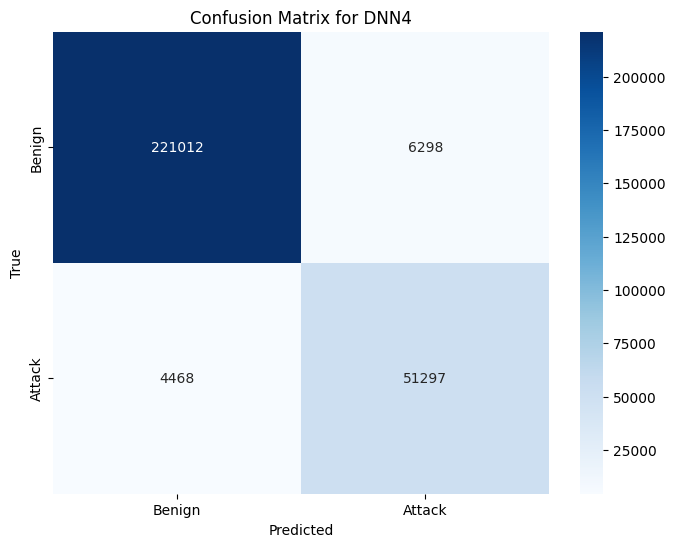

In [23]:
# Evaluate the best model
# Predict probabilities on the evaluation set
y_pred_eval_prob = model4.predict(scaler.transform(X_eval))
# Convert probabilities to binary predictions
y_pred_eval = (y_pred_eval_prob > 0.5).astype(int)
metrics_report("Evaluation", Y_eval.is_attack, y_pred_eval, print_avg=False)

# Predict and evaluate on the test set
y_pred_test_prob = model4.predict(scaler.transform(X_test))
y_pred_test = (y_pred_test_prob > 0.5).astype(int)
performance_models["DNN4"] = metrics_report("Test", Y_test.is_attack, y_pred_test, print_avg=False)
plot_confusion_matrix("DNN4", Y_test, y_pred_test)

## 5. Layers and different metric for hyperparameter optimization

In [24]:
# Define the build_model3 function with four dense layers
def build_model4(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units_2', min_value=16, max_value=256, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units_3', min_value=16, max_value=256, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units_4', min_value=16, max_value=256, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_4', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [25]:
# Initialize the tuner
directory_path = os.path.join(os.getcwd(), 'hyperparam_tuning_hypermodel4')
tuner = kt.RandomSearch(
    build_model4,  
    objective='accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory=directory_path,
    project_name='intrusion_detection_hypermodel4'
)
tuner.search_space_summary()

Search space summary
Default search space size: 9
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_2 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_3 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_4 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 

In [26]:
# Perform the search
tuner.search(scaler.transform(X_train), Y_train['is_attack'], epochs=10, validation_split=0.2)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hps.values)

Trial 10 Complete [00h 39m 48s]
accuracy: 0.9534268975257874

Best accuracy So Far: 0.9665588438510895
Total elapsed time: 05h 49m 06s
Best Hyperparameters: {'units_1': 192, 'dropout_1': 0.1, 'units_2': 80, 'dropout_2': 0.1, 'units_3': 16, 'dropout_3': 0.2, 'units_4': 240, 'dropout_4': 0.4, 'learning_rate': 0.00011617848168321534}


In [27]:
# Build the model with the best hyperparameters
model5 = build_model4(best_hps)
# Add early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Train the model
history = model5.fit(scaler.transform(X_train), Y_train.is_attack, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
save_keras_model(model5, 'DNN_model5')

Epoch 1/50
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 114s 1ms/step - accuracy: 0.9380 - loss: 0.1428 - val_accuracy: 0.3551 - val_loss: 4.4268
Epoch 2/50
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 108s 1ms/step - accuracy: 0.9609 - loss: 0.0864 - val_accuracy: 0.3682 - val_loss: 2.2838
Epoch 3/50
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 108s 1ms/step - accuracy: 0.9633 - loss: 0.0815 - val_accuracy: 0.3609 - val_loss: 2.0058
Epoch 4/50
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 108s 1ms/step - accuracy: 0.9640 - loss: 0.0797 - val_accuracy: 0.3459 - val_loss: 1.9149
Epoch 5/50
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 108s 1ms/step - accuracy: 0.9645 - loss: 0.0783 - val_accuracy: 0.3781 - val_loss: 1.7849
Epoch 6/50
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 108s 1ms/step - accuracy: 0.9648 - loss: 0.0772 - val_accuracy: 0.4870 - val_loss: 1.3252
Epoch 7/50
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 109s 1ms/step - accuracy: 0.9654 - loss: 0.0756 - val_accuracy: 0.4858 - val_loss: 1.5551
Epoch 8/50
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 108s 1ms/step - ac

8847/8847 ━━━━━━━━━━━━━━━━━━━━ 4s 492us/step
Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.9931    0.9680    0.9804    227310
           1     0.8817    0.9725    0.9249     55764

    accuracy                         0.9689    283074
   macro avg     0.9374    0.9703    0.9526    283074
weighted avg     0.9711    0.9689    0.9694    283074

Accuracy: 0.9688773960165893
8847/8847 ━━━━━━━━━━━━━━━━━━━━ 4s 496us/step
Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9932    0.9674    0.9801    227310
           1     0.8799    0.9728    0.9241     55765

    accuracy                         0.9685    283075
   macro avg     0.9365    0.9701    0.9521    283075
weighted avg     0.9709    0.9685    0.9691    283075

Accuracy: 0.9684995142630045


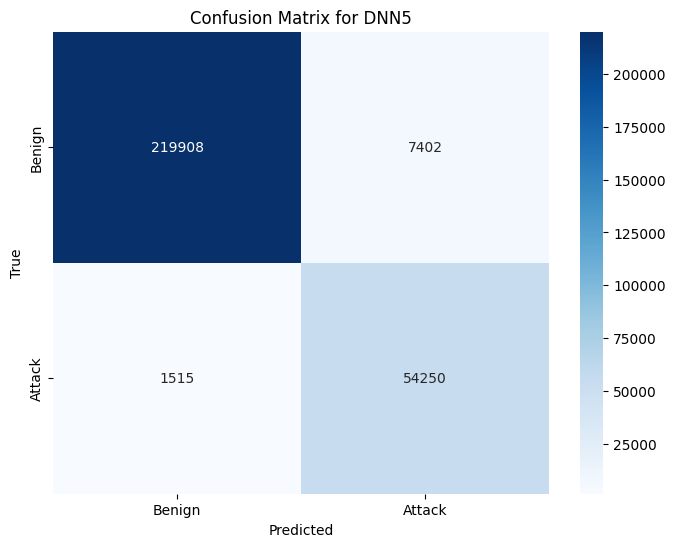

In [28]:
# Evaluate the best model
# Predict probabilities on the evaluation set
y_pred_eval_prob = model5.predict(scaler.transform(X_eval))
# Convert probabilities to binary predictions
y_pred_eval = (y_pred_eval_prob > 0.5).astype(int)
metrics_report("Evaluation", Y_eval.is_attack, y_pred_eval, print_avg=False)

# Predict and evaluate on the test set
y_pred_test_prob = model5.predict(scaler.transform(X_test))
y_pred_test = (y_pred_test_prob > 0.5).astype(int)
performance_models["DNN5"] = metrics_report("Test", Y_test.is_attack, y_pred_test, print_avg=False)
plot_confusion_matrix("DNN5", Y_test, y_pred_test)

## 6. Conclusion

[0.9395071977391151, 0.9544608319349995, 0.9611551708911066, 0.9619676764108451, 0.9684995142630045]
['DNN1', 'DNN2', 'DNN3', 'DNN4', 'DNN5']


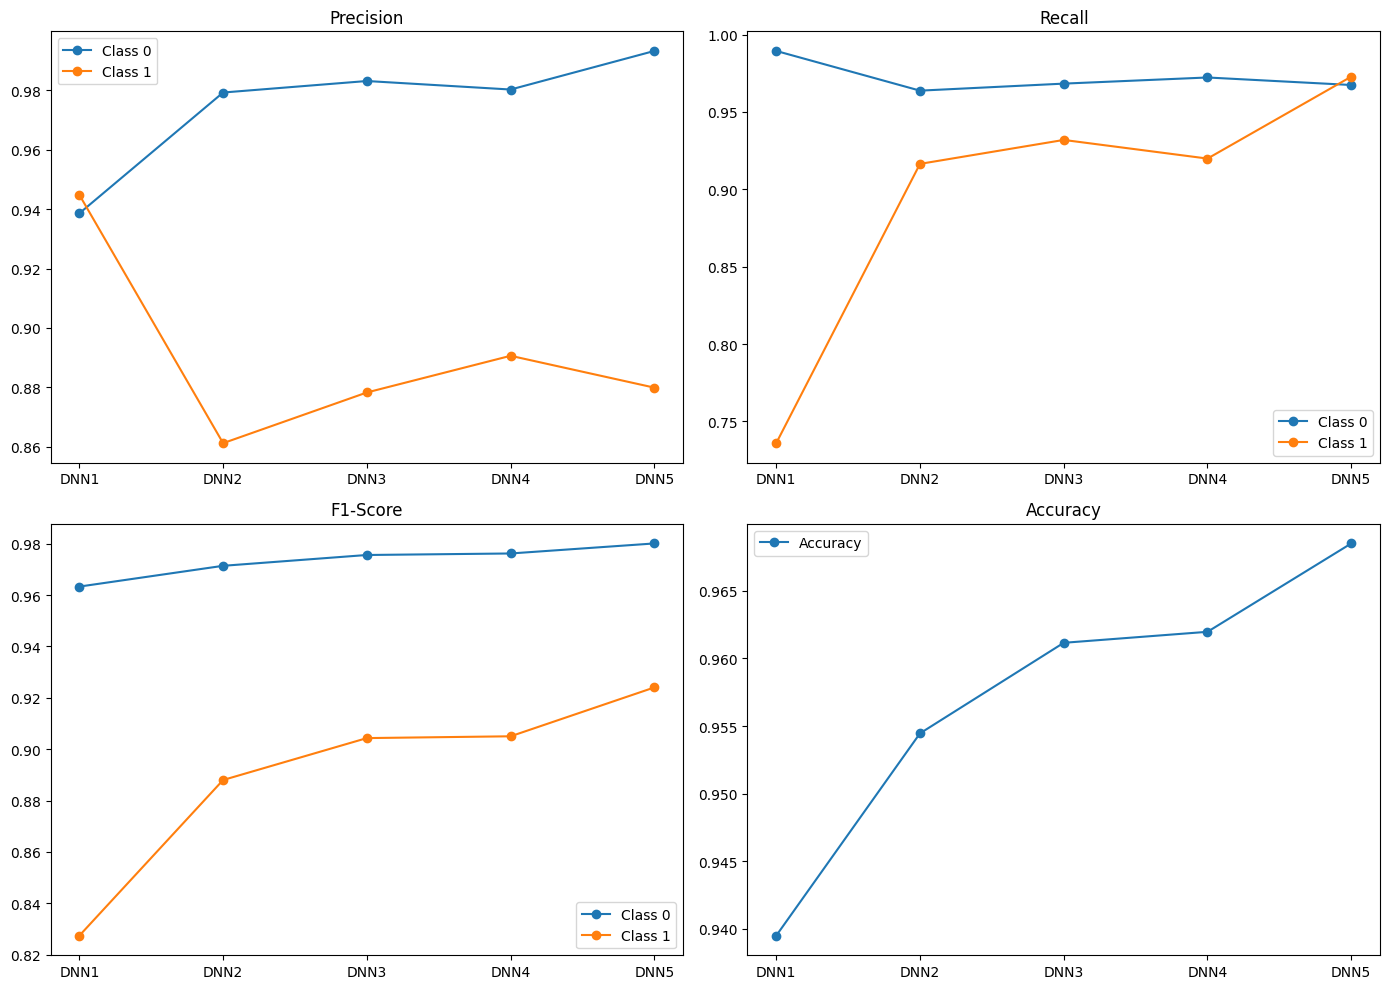

In [29]:
extract_and_plot_metrics(performance_models)